# [실습] MovieLens 데이터를 활용한 지식 그래프 구축

본 실습에서는 대량의 CSV 데이터를 파이썬을 사용하여 지식 그래프로 변환하는 파이프라인을 구축합니다

- MovieLens 데이터셋 다운로드 링크: https://grouplens.org/datasets/movielens/latest/

# 1. Python 환경 설정

In [1]:
# 필요한 라이브러리 설치 (1회성 실행)
!pip install rdflib pandas

# 라이브러리 임포트
import pandas as pd
from rdflib import Graph, Namespace, Literal
from rdflib.namespace import RDF, RDFS, OWL, XSD

Defaulting to user installation because normal site-packages is not writeable


# 2. 온톨로지 정의

**상세 과정**: [온톨로지 설계 방법](https://hi2world.tistory.com/entry/2-%EC%98%A8%ED%86%A8%EB%A1%9C%EC%A7%80-%EC%84%A4%EA%B3%84-MovieLens-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8B%A4%EC%8A%B5)

**결과**

클래스 (4개):
- ex:Movie - 영화
- ex:Genre - 장르
- ex:Person - 사람 (사용자, 감독, 배우 등의 부모 클래스)
- ex:ReviewEvent - 평가 사건

객체 속성 (3개):
- ex:belongsToGenre (ex:Movie → ex:Genre)
- ex:ratedBy (ex:ReviewEvent → ex:Person)
- ex:aboutMovie (ex:ReviewEvent → ex:Movie)

데이터 속성 (4개):
- ex:title (ex:Movie → string)
- ex:genreName (ex:Genre → string)
- ex:hasScore (ex:ReviewEvent → decimal)
- ex:timestamp (ex:ReviewEvent → integer)

## 온톨로지 생성
온톨로지를 별도로 저장하여 재사용성을 높입니다.

In [2]:
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS, OWL, XSD

# 온톨로지 전용 그래프
ontology_g = Graph()
ex = Namespace("http://example.org/movielens#")
ontology_g.bind("ex", ex)
ontology_g.bind("owl", OWL)
ontology_g.bind("rdfs", RDFS)

### 클래스 정의

```bash
# 최상위 클래스
ex:Person a owl:Class .

# 하위 클래스 (subClassOf)
ex:User a owl:Class ;
    rdfs:subClassOf ex:Person .

ex:Movie a owl:Class .
ex:Genre a owl:Class .
ex:ReviewEvent a owl:Class .
```

In [3]:
# 클래스
Person = ex.Person
User = ex.User
Movie = ex.Movie
Genre = ex.Genre
ReviewEvent = ex.ReviewEvent

# 최상위 클래스
ontology_g.add((Person, RDF.type, OWL.Class))

# 하위 클래스 (subClassOf)
ontology_g.add((User, RDF.type, OWL.Class))
ontology_g.add((User, RDFS.subClassOf, Person))

ontology_g.add((Movie, RDF.type, OWL.Class))
ontology_g.add((Genre, RDF.type, OWL.Class))
ontology_g.add((ReviewEvent, RDF.type, OWL.Class))

<Graph identifier=N858d32392c0e42f4ba0431ad52dc2565 (<class 'rdflib.graph.Graph'>)>

### 객체 속성 정의

```bash
ex:belongsToGenre a owl:ObjectProperty ;
    rdfs:domain ex:Movie ;
    rdfs:range ex:Genre .

ex:ratedBy a owl:ObjectProperty ;
    rdfs:domain ex:ReviewEvent ;
    rdfs:range ex:Person .

ex:aboutMovie a owl:ObjectProperty ;
    rdfs:domain ex:ReviewEvent ;
    rdfs:range ex:Movie .

# 역관계 정의
ex:hasReview a owl:ObjectProperty ;
    owl:inverseOf ex:aboutMovie ;
    rdfs:domain ex:Movie ;
    rdfs:range ex:ReviewEvent .
```

In [4]:
# 객체 속성
belongsToGenre = ex.belongsToGenre
ratedBy = ex.ratedBy
aboutMovie = ex.aboutMovie
hasReview = ex.hasReview

# belongsToGenre
ontology_g.add((belongsToGenre, RDF.type, OWL.ObjectProperty))
ontology_g.add((belongsToGenre, RDFS.domain, Movie))
ontology_g.add((belongsToGenre, RDFS.range, Genre))

# ratedBy
ontology_g.add((ratedBy, RDF.type, OWL.ObjectProperty))
ontology_g.add((ratedBy, RDFS.domain, ReviewEvent))
ontology_g.add((ratedBy, RDFS.range, Person))

# aboutMovie
ontology_g.add((aboutMovie, RDF.type, OWL.ObjectProperty))
ontology_g.add((aboutMovie, RDFS.domain, ReviewEvent))
ontology_g.add((aboutMovie, RDFS.range, Movie))

# hasReview (역관계)
ontology_g.add((hasReview, RDF.type, OWL.ObjectProperty))
ontology_g.add((hasReview, OWL.inverseOf, aboutMovie))
ontology_g.add((hasReview, RDFS.domain, Movie))
ontology_g.add((hasReview, RDFS.range, ReviewEvent))

<Graph identifier=N858d32392c0e42f4ba0431ad52dc2565 (<class 'rdflib.graph.Graph'>)>

### 데이터 속성 정의

```bash
ex:title a owl:DatatypeProperty ;
    rdfs:domain ex:Movie ;
    rdfs:range xsd:string .

ex:genreName a owl:DatatypeProperty ;
    rdfs:domain ex:Genre ;
    rdfs:range xsd:string .

ex:hasScore a owl:DatatypeProperty ;
    rdfs:domain ex:ReviewEvent ;
    rdfs:range xsd:decimal .

ex:timestamp a owl:DatatypeProperty ;
    rdfs:domain ex:ReviewEvent ;
    rdfs:range xsd:integer .
```

In [5]:
# 데이터 속성
title = ex.title
genreName = ex.genreName
hasScore = ex.hasScore
timestamp = ex.timestamp

# title
ontology_g.add((title, RDF.type, OWL.DatatypeProperty))
ontology_g.add((title, RDFS.domain, Movie))
ontology_g.add((title, RDFS.range, XSD.string))

# genreName
ontology_g.add((genreName, RDF.type, OWL.DatatypeProperty))
ontology_g.add((genreName, RDFS.domain, Genre))
ontology_g.add((genreName, RDFS.range, XSD.string))

# hasScore
ontology_g.add((hasScore, RDF.type, OWL.DatatypeProperty))
ontology_g.add((hasScore, RDFS.domain, ReviewEvent))
ontology_g.add((hasScore, RDFS.range, XSD.decimal))

# timestamp
ontology_g.add((timestamp, RDF.type, OWL.DatatypeProperty))
ontology_g.add((timestamp, RDFS.domain, ReviewEvent))
ontology_g.add((timestamp, RDFS.range, XSD.integer))

<Graph identifier=N858d32392c0e42f4ba0431ad52dc2565 (<class 'rdflib.graph.Graph'>)>

## 온톨로지 저장

In [6]:
# 온톨로지 파일로 저장
ontology_g.serialize(destination='movielens_ontology.ttl', format='turtle')

print(f"온톨로지 저장 완료")
print(f"- 파일: movielens_ontology.ttl")
print(f"- 트리플 수: {len(ontology_g)}개")

온톨로지 저장 완료
- 파일: movielens_ontology.ttl
- 트리플 수: 31개


# 3. CSV 데이터 변환

### 온톨로지 파일 로드

In [7]:
import pandas as pd
from rdflib import Graph, Namespace, Literal
from rdflib.namespace import RDF, XSD

# 데이터 그래프
data_g = Graph()

# 온톨로지 로드
data_g.parse('movielens_ontology.ttl', format='turtle')
print("온톨로지 로드 완료")

ex = Namespace("http://example.org/movielens#")
data_g.bind("ex", ex)

온톨로지 로드 완료


### 데이터 로드

In [8]:
# CSV 로드
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

### URI 정제 함수
genres 컬럼에 (no genres listed), Film-Noir 같은 특수문자가 포함되어 있어 URI로 사용할 수 없습니다.

In [9]:
def sanitize_uri(text):
    """
    URI에 사용할 수 없는 문자 제거
    예: '(no genres listed)' → 'nogenreslisted'
        'Film-Noir' → 'FilmNoir'
    """
    return text.replace("(", "").replace(")", "").replace(" ", "").replace("-", "")

# 테스트
print(sanitize_uri("(no genres listed)"))  # nogenreslisted
print(sanitize_uri("Film-Noir"))           # FilmNoir

nogenreslisted
FilmNoir


### movies.csv 변환
영화 데이터를 읽어 ex:Movie 인스턴스를 생성하고, 장르 정보를 ex:Genre 클래스와 객체 속성으로 연결합니다.

In [10]:
genres_set = set()

for _, row in movies_df.iterrows():
    movie_uri = ex[f"movie_{row['movieId']}"]
    
    # 1. 영화 인스턴스 및 데이터 속성 추가
    data_g.add((movie_uri, RDF.type, ex.Movie))
    data_g.add((movie_uri, ex.title, Literal(row['title'], datatype=XSD.string)))
    
    # 2. 장르 연결 (객체 속성)
    if pd.notna(row['genres']):
        for genre_name in row['genres'].split('|'):
            safe_genre = genre_name.replace(" ", "")
            genre_uri = ex[f"genre_{safe_genre}"]
            
            # 장르 클래스 인스턴스 생성 (중복 방지)
            if safe_genre not in genres_set:
                data_g.add((genre_uri, RDF.type, ex.Genre))
                data_g.add((genre_uri, ex.genreName, Literal(genre_name, datatype=XSD.string)))
                genres_set.add(safe_genre)
            
            # 영화 - [belongsToGenre] -> 장르 연결
            data_g.add((movie_uri, ex.belongsToGenre, genre_uri))

특정 영화 하나를 골라 그 영화와 연결된 모든 정보를 출력해보겠습니다.

In [11]:
# 확인용 예시: 첫 번째 영화의 모든 연결 정보 출력
test_movie_uri = ex["movie_1"]

print(f"\n[데이터 예시: {test_movie_uri}]")
for s, p, o in data_g.triples((test_movie_uri, None, None)):
    # URI에서 사람이 읽기 쉬운 이름만 추출 (예: http://...#title -> ex:title)
    pred = p.split('#')[-1]
    
    # 목적어가 URI인지 리터럴(값)인지에 따라 출력 처리
    if isinstance(o, Literal):
        obj = f"\"{o}\""
    else:
        obj = f"ex:{o.split('#')[-1]}"
        
    print(f"  - {pred:<15} : {obj}")


[데이터 예시: http://example.org/movielens#movie_1]
  - type            : ex:Movie
  - title           : "Toy Story (1995)"
  - belongsToGenre  : ex:genre_Adventure
  - belongsToGenre  : ex:genre_Animation
  - belongsToGenre  : ex:genre_Children
  - belongsToGenre  : ex:genre_Comedy
  - belongsToGenre  : ex:genre_Fantasy


### ratings.csv 변환
사용자와 영화 사이의 '평점'이라는 관계를 ex:ReviewEvent라는 독립된 객체로 변환합니다. 이를 통해 평점 점수와 시간 정보를 논리적으로 연결할 수 있습니다.

💡 이벤트 중심 모델링: 단순히 User와 Movie를 선으로 잇지 않고 ReviewEvent를 거쳐가게 함으로써, "4.0점"이라는 점수가 누구의 것도 아닌 '그 사건'의 속성임을 명확히 합니다.

In [12]:
users_set = set()

for index, row in ratings_df.iterrows():
    user_id = int(row['userId'])
    user_uri = ex[f"user_{user_id}"]
    
    # 1. 사용자 인스턴스 생성
    if user_id not in users_set:
        data_g.add((user_uri, RDF.type, ex.User))
        users_set.add(user_id)
    
    # 2. 리뷰 이벤트 생성 (중심점 역할)
    review_uri = ex[f"rating_{index}"]
    movie_uri = ex[f"movie_{int(row['movieId'])}"]
    
    data_g.add((review_uri, RDF.type, ex.ReviewEvent))
    data_g.add((review_uri, ex.ratedBy, user_uri))    # 누가
    data_g.add((review_uri, ex.aboutMovie, movie_uri)) # 어떤 영화를
    data_g.add((review_uri, ex.hasScore, Literal(row['rating'], datatype=XSD.decimal))) # 몇 점으로
    data_g.add((review_uri, ex.timestamp, Literal(int(row['timestamp']), datatype=XSD.integer))) # 언제

특정 리뷰 하나를 골라 그 리뷰와 연결된 모든 정보를 출력해보겠습니다.

In [13]:
# 확인용 예시: 첫 번째 평점 이벤트(rating_0) 정보 추출
test_rating_uri = ex["rating_0"]

print(f"\n[데이터 예시: {test_rating_uri}]")
for s, p, o in data_g.triples((test_rating_uri, None, None)):
    pred = p.split('#')[-1]
    
    # 목적어 처리 (Literal vs URI)
    if isinstance(o, Literal):
        obj = f"{o} (Value)"
    else:
        obj = f"ex:{o.split('#')[-1]} (Resource)"
        
    print(f"  - {pred:<12} : {obj}")


[데이터 예시: http://example.org/movielens#rating_0]
  - type         : ex:ReviewEvent (Resource)
  - ratedBy      : ex:user_1 (Resource)
  - aboutMovie   : ex:movie_1 (Resource)
  - hasScore     : 4.0 (Value)
  - timestamp    : 964982703 (Value)


### 지식 그래프 저장
변환된 모든 트리플을 Turtle 파일로 저장합니다.

In [14]:
# 데이터 파일로 저장
data_g.serialize(destination='movielens_data.ttl', format='turtle')

print(f"데이터 저장 완료")
print(f"- 파일: movielens_data.ttl")
print(f"- 생성된 총 트리플 수: {len(data_g):,}개")

데이터 저장 완료
- 파일: movielens_data.ttl
- 생성된 총 트리플 수: 546,429개


# 4. 결과 확인
## 지식 그래프 로드 및 통계
온톨로지와 데이터를 함께 로드하여 완전한 지식 그래프를 구성합니다.

In [15]:
from rdflib import Graph, RDF, OWL

# 전체 지식 그래프 로드
kg = Graph()
kg.parse('movielens_data.ttl', format='turtle')

# 1. 온톨로지에 정의된 모든 클래스(OWL.Class) 자동 추출
classes = sorted(list(kg.subjects(RDF.type, OWL.Class)))

print(f"{'='*50}")
print(f"지식 그래프 구축 완료 및 자동 통계")
print(f"{'='*50}")

print(f"\n[클래스별 인스턴스 통계]")
for cls in classes:
    # 클래스의 짧은 이름 추출 (예: http://...#Movie -> Movie)
    class_name = cls.split('#')[-1]
    
    # 해당 클래스 타입을 가진 인스턴스 개수 계산
    count = len(list(kg.subjects(RDF.type, cls)))
    
    print(f"- {class_name:<12} : {count:>7,}개")

# 2. 전체 관계(Triple) 수 출력
print(f"\n[전체 통계]")
print(f"- 전체 트리플(Triple) 수: {len(kg):,}개")
print(f"{'='*50}")

지식 그래프 구축 완료 및 자동 통계

[클래스별 인스턴스 통계]
- Genre        :      20개
- Movie        :   9,742개
- Person       :       0개
- ReviewEvent  : 100,836개
- User         :     610개

[전체 통계]
- 전체 트리플(Triple) 수: 546,429개


## 시각화

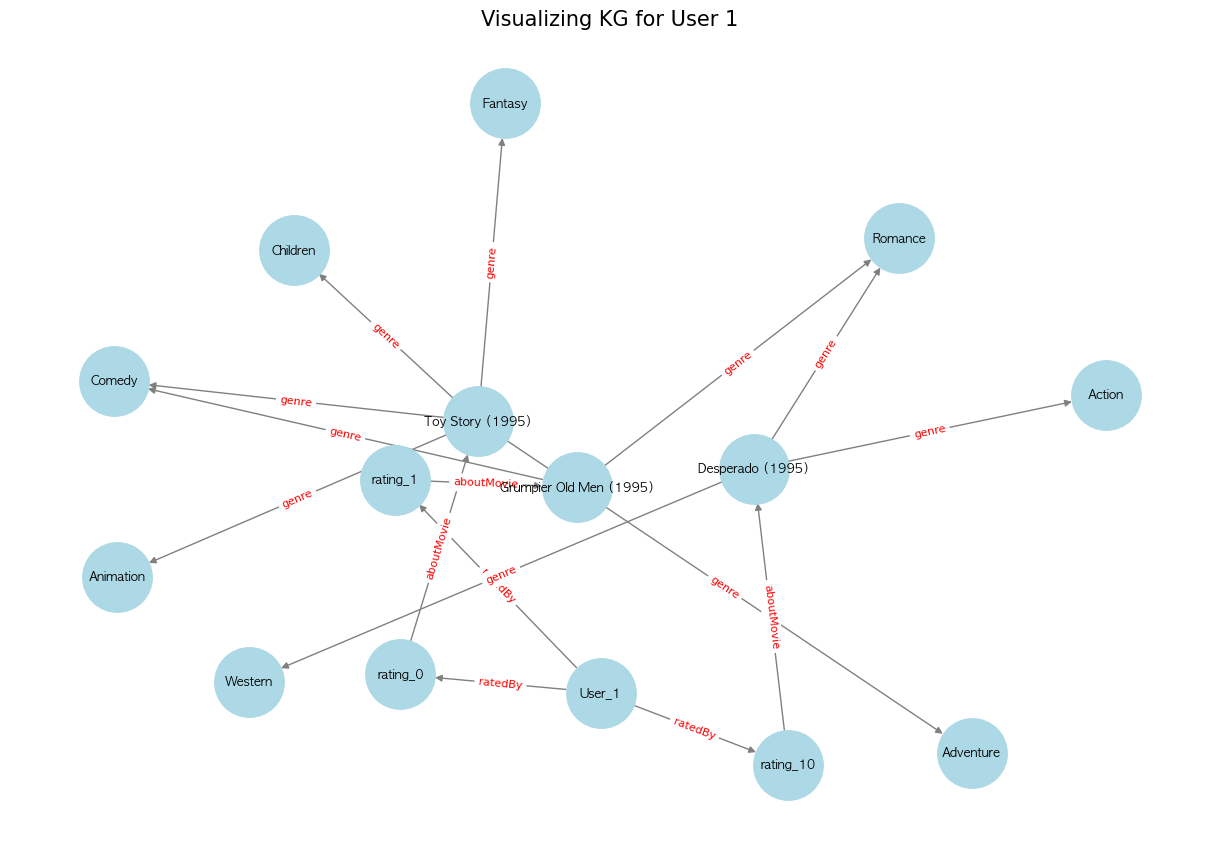

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace

# 1. 그래프 객체 생성 및 데이터 로드
kg = Graph()
kg.parse('movielens_data.ttl', format='turtle')

# 2. 네임스페이스 설정 (시각화 시 라벨 추출을 위해 필요)
ex = Namespace("http://example.org/movielens#")

def draw_knowledge_graph(g, target_id="1", max_rel=5):
    G = nx.DiGraph()
    target_user = ex[f"user_{target_id}"]
    
    # 지식 탐색: 사용자 -> 리뷰 -> 영화 -> 장르
    for review in g.subjects(ex.ratedBy, target_user):
        if max_rel <= 0: break
        
        # 노드 및 엣지 추가 (User -> Review)
        u_label = f"User_{target_id}"
        r_label = str(review).split('#')[-1]
        G.add_edge(u_label, r_label, label="ratedBy")
        
        # (Review -> Movie)
        movie = g.value(review, ex.aboutMovie)
        if movie:
            m_title = str(g.value(movie, ex.title))
            m_label = m_title if m_title else str(movie).split('#')[-1]
            G.add_edge(r_label, m_label, label="aboutMovie")
            
            # (Movie -> Genre)
            for _, _, genre in g.triples((movie, ex.belongsToGenre, None)):
                g_name = str(g.value(genre, ex.genreName))
                G.add_edge(m_label, g_name, label="genre")
        
        max_rel -= 1

    # 시각화 레이아웃 및 스타일 설정
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=1.0)
    
    nx.draw(G, pos, with_labels=True, 
            node_color='lightblue', node_size=2500, 
            font_size=9, font_family='AppleGothic', # 윈도우는 'Malgun Gothic'
            edge_color='gray', arrows=True)
    
    # 관계명(Edge Label) 표시
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')
    
    plt.title(f"Visualizing KG for User {target_id}", size=15)
    plt.show()

# 시각화 실행
draw_knowledge_graph(kg, target_id="1", max_rel=3)

## 역관계 추론 예시
ex:hasReview를 정의했으므로 OWL 추론 엔진 사용 시 자동 추론이 가능합니다.

```bash
# 명시적으로 입력한 데이터
ex:rating_0 ex:aboutMovie ex:movie_1 .

# OWL 추론 엔진이 자동으로 추론
ex:movie_1 ex:hasReview ex:rating_0 .
```

In [17]:
#!pip install owlrl
import owlrl

# 1. 추론 엔진(Inference Engine) 가동
# 온톨로지(T-Box)에 정의된 논리 규칙(예: owl:inverseOf)을 실제 데이터(A-Box)에 적용합니다.
# 이 과정을 통해 'A가 B를 참조한다'는 데이터로부터 'B는 A에 의해 참조된다'는 새로운 지식을 자동으로 생성합니다.
owlrl.DeductiveClosure(owlrl.OWLRL_Semantics).expand(kg)

# 2. 역관계(Inverse Property)를 이용한 데이터 조회
# 원래 데이터에는 [Review -> Movie] 방향만 존재하지만, 
# 추론을 통해 생성된 [Movie -> Review] (ex:hasReview) 관계를 사용하여 쿼리를 던집니다.
query = """
PREFIX ex: <http://example.org/movielens#>
SELECT ?review ?score
WHERE {
    # 온톨로지 규칙으로 자동 생성된 'hasReview' 관계를 사용하여 영화 중심의 탐색 수행
    ex:movie_1 ex:hasReview ?review .
    ?review ex:hasScore ?score .
}
LIMIT 5
"""

print("\n[추론 후 SPARQL 결과: ex:movie_1의 리뷰 목록]")
# kg(그래프) 내에 물리적으로 생성된 역방향 트리플들을 찾아 결과를 출력합니다.
for row in kg.query(query):
    print(f"리뷰 ID: {row.review.split('#')[-1]} | 점수: {row.score}")


[추론 후 SPARQL 결과: ex:movie_1의 리뷰 목록]
리뷰 ID: rating_67080 | 점수: 4.0
리뷰 ID: rating_19179 | 점수: 4.0
리뷰 ID: rating_56364 | 점수: 3.0
리뷰 ID: rating_58965 | 점수: 4.0
리뷰 ID: rating_98479 | 점수: 4.0
